Google Colab initial Steps

# Catalog Exploration

This python notebook will provide the first steps and ideas to analyze the radio catalog to be used for the internship

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.metrics import mean_squared_log_error, plot_confusion_matrix, classification_report, explained_variance_score

import lightgbm as lgb

plt.style.use('seaborn')


import os.path

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### The data can be accessed and loaded directly for a server at the OAL

In [2]:
table_RACS_catalogue_URL = 'http://oal.ul.pt/data/AlmaQA2/Catalogs_cV1ax509ZbXXx978pb3/RACS_VEXAS_ALLWISE_DES_PS1_SkyMapper_specZ_milliquas_v3.fits.gz'
table_RACS_cat = Table.read(table_RACS_catalogue_URL)

table_RACS_cat_df = table_RACS_cat.to_pandas() # convert to Pandas Dataframe

### ...OR it can directly downloaded locally for later reading. 

In [ ]:
cats_path = '/content/'
filepath = cats_path +  'RACS_VEXAS_ALLWISE_DES_PS1_SkyMapper_specZ_milliquas_v3.fits.gz'
if os.path.isfile(filepath):
  print('Catalog file already in local dir...loading it directly')
else:
  print('Downloading catalog...')
  !wget http://oal.ul.pt/data/AlmaQA2/Catalogs_cV1ax509ZbXXx978pb3/RACS_VEXAS_ALLWISE_DES_PS1_SkyMapper_specZ_milliquas_v3.fits.gz
  print('Loading it...')
  
table_RACS_cat = Table.read(filepath)  

print(''); print('Table read'); print('')

table_RACS_cat_df = table_RACS_cat.to_pandas()

print('Table converted to Pandas dataframe as "table_RACS_cat_df"')


--2021-07-13 08:35:18--  http://oal.ul.pt/data/AlmaQA2/Catalogs_cV1ax509ZbXXx978pb3/RACS_VEXAS_ALLWISE_DES_PS1_SkyMapper_specZ_milliquas_v3.fits.gz
Resolving oal.ul.pt (oal.ul.pt)... 194.117.9.112
Connecting to oal.ul.pt (oal.ul.pt)|194.117.9.112|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89572117 (85M) [application/x-gzip]
Saving to: ‘RACS_VEXAS_ALLWISE_DES_PS1_SkyMapper_specZ_milliquas_v3.fits.gz’

RACS_VEXAS_ALLWISE_ 100%[===================>]  85.42M  18.5MB/s    in 5.8s    

2021-07-13 08:35:27 (14.7 MB/s) - ‘RACS_VEXAS_ALLWISE_DES_PS1_SkyMapper_specZ_milliquas_v3.fits.gz’ saved [89572117/89572117]

Loading it...

Table read

Table converted to Pandas dataframe as "table_RACS_cat_df"


### The Pandas framework provides a convenient set of tools for data manipulation

General information about the loaded table can be obtained with the ``info`` funtion

In [3]:
table_RACS_cat_df.info(null_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259252 entries, 0 to 259251
Data columns (total 167 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   col1                   259252 non-null  int32  
 1   id                     259252 non-null  int32  
 2   catalogue_id           259252 non-null  int16  
 3   n_components           259252 non-null  int16  
 4   ra_deg_cont            259252 non-null  float64
 5   dec_deg_cont           259252 non-null  float64
 6   freq                   259252 non-null  float32
 7   maj_axis               259252 non-null  float32
 8   min_axis               259252 non-null  float32
 9   pos_ang                259252 non-null  float32
 10  flux_int               259252 non-null  float64
 11  flux_int_err           259252 non-null  float32
 12  flux_peak              259252 non-null  float64
 13  mean_background        259252 non-null  float32
 14  background_noise       259252 non-n

Pandas includes many useful functions to locate and select data.

The example below will look through all the table and list the one that include "W1" in their name

In [4]:
table_RACS_cat_df.loc[:,['W1' in i for i in table_RACS_cat_df.columns]]

,W1MAG,E_W1MAG
0,15.325,0.037
1,11.750,0.023
2,12.883,0.024
3,11.962,0.024
4,16.527,0.088
...,...,...
259247,11.791,0.023
259248,15.162,0.038
259249,14.622,0.028
259250,11.406,0.023


### **Describing the catalogue...**

This description will require checking the original papers and webpages that describe the data:

The core catalogue is based in the radio catalogue "Rapid ASKAP Cntinuum Survey ([RACS](https://research.csiro.au/racs/))"

It has been then cross-correlated with:
* the VEXAS compilation in the Near-IR ([link](https://www.eso.org/qi/catalog/show/318) and [description](https://www.eso.org/rm/api/v1/public/releaseDescriptions/146)); 
* Dark Energy Survey (DES; optical; [link1](https://www.darkenergysurvey.org/) & [paper](https://arxiv.org/abs/1801.03181)); 
* PanSTARRS (PS1; optical; [link](https://panstarrs.stsci.edu/) & [description](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwjS6f3_zMTxAhXE_qQKHZanA90QFjAAegQIBRAD&url=https%3A%2F%2Fwww.ifa.hawaii.edu%2Fastrocoffee%2Fps1dr1catalogcheetsheet.pdf&usg=AOvVaw2ARGOc_boIx4YUy3VVHkET)). 
* [SkyMapper](http://skymapper.anu.edu.au/) (optical; 

The spectroscopy comes from the VEXAS compilation itself (dominated by SDSS) and from the Million Quasar Catalogue ([link](http://quasars.org/milliquas.htm)). It has about 260000 target with about 25k redshifts (stars, galaxies and AGNs)  but the format can still be improved (i.e several columns repeated and some other info not condensed in same columns, like milliquas info)



### Identify the number of "Null/NaNs" in each column of the dataframe

In [5]:
for cols in table_RACS_cat_df.columns:
  num_nulls = table_RACS_cat_df[cols].isnull().sum()
  print('Number of NaN in column ', cols, ': ', str(num_nulls))

Number of NaN in column  col1 :  0
Number of NaN in column  id :  0
Number of NaN in column  catalogue_id :  0
Number of NaN in column  n_components :  0
Number of NaN in column  ra_deg_cont :  0
Number of NaN in column  dec_deg_cont :  0
Number of NaN in column  freq :  0
Number of NaN in column  maj_axis :  0
Number of NaN in column  min_axis :  0
Number of NaN in column  pos_ang :  0
Number of NaN in column  flux_int :  0
Number of NaN in column  flux_int_err :  0
Number of NaN in column  flux_peak :  0
Number of NaN in column  mean_background :  0
Number of NaN in column  background_noise :  0
Number of NaN in column  n_pix :  0
Number of NaN in column  beam_area :  0
Number of NaN in column  quality_level :  0
Number of NaN in column  GAL_LONG_1 :  74358
Number of NaN in column  GAL_LAT_1 :  74358
Number of NaN in column  SOURCEID_VISTA_1 :  74358
Number of NaN in column  SLAVEOBJID_WISE_1 :  74358
Number of NaN in column  COADD_OBJECT_ID_DES :  74358
Number of NaN in column  RA_D

Checking sky distribution of sources

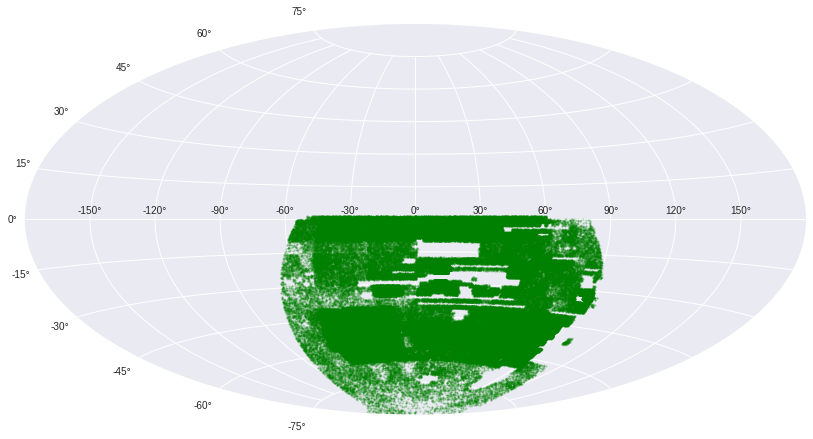

In [6]:
RACS_coords = SkyCoord(table_RACS_cat_df['RA_ALLWISE'], table_RACS_cat_df['DEC_ALLWISE'], unit=u.deg)

fig = plt.figure(figsize=(14,9))
ax1 = fig.add_subplot(111, projection='aitoff')

ax1.grid(True)
ax1.plot(RACS_coords.ra.wrap_at(180*u.degree).rad, RACS_coords.dec.rad, 'o', markersize=2, alpha=0.3, color='green')
# fig.subplots_adjust(top=0.95,bottom=0.0)

**TASK**: It would be interesting to compare the sky distribbution of all the surveys contained within the catalog:

* RACS: *ra_deg_cont, dec_deg_cont*
* VEXAS + ALLWISE: 
  * DES: RA_DES, DEC_DES
  * PanSTARRS: *RA_PS*, *DEC_PS*
  * SkyMapper: *RA_SM, DEC_SM*

---

## Plotting

Ploting can easily be done with the ``seaborn`` library
Below follows and example of an histogram. In the future we will see other plotting capabilities of ``seaborn``

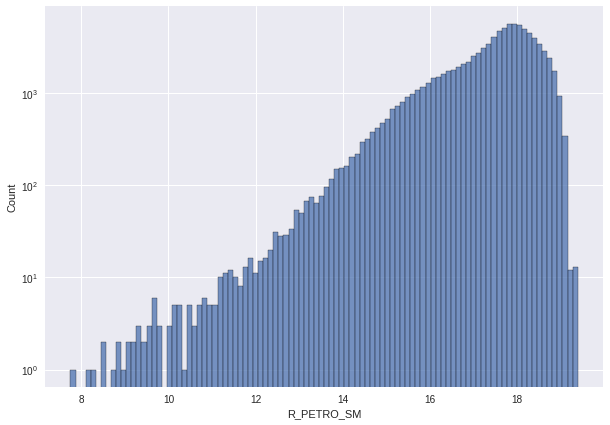

In [ ]:
plt.figure(figsize=(10,7))
ax = sns.histplot(table_RACS_cat_df['R_PETRO_SM'], bins=100)
ax.set_yscale("log")


---
**TASK**:

Plot the histogram distribution for some of the magnitudes of the different surveys 

**TASK**: How would you combine the data from the different surveys?

**TASK**: what is the magnitude reference system used in each survey? (Vega or AB)